### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import train_test_split

pd.set_option('display.width', None)
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Functions

In [2]:
def drop_by_index(X,indexes):
    """
    helper function to drop rows of dataframe and return new dataframe without those rows with indexes resetted
    """
    X = X.drop(indexes)
    X = X.reset_index().drop(columns="index")
    return(X)

def dataSetting(dropCol,FILE_FOLDER = "C:\\SMU_v2\\"):
    '''
    function to read the pkl from from datasource
        1. Remove dx_date that is NULL.
        2. Drop all rows where crucial fields for X_features are NULL.
        3. Convert Date columns into datetime format
        4. Derive OS, CSS, DFS days based on dx_date
        5. Create status column to indicate if the patient is dead or alive base on if death_age exists
    '''
    df = pd.read_pickle(FILE_FOLDER + "clinical_output.pkl").reset_index().drop(columns="index")
    to_drop = df[df['dx_date']=="NA"].index
    df = drop_by_index(df,to_drop)

    df.drop(columns=dropCol,inplace = True)

    # drop all rows where dates are null
    df.dropna(axis=0,\
                    subset=['Date_for_DFS','Date_for_OS','Date_for_CSS','dx_date','size_precise', 'nodespos'],\
                    inplace=True)

    # convert all datetime in dataframe into dateime format for processing
    df["Date_for_DFS"] = pd.to_datetime(df["Date_for_DFS"])
    df["Date_for_OS"] = pd.to_datetime(df["Date_for_OS"])
    df["Date_for_CSS"] = pd.to_datetime(df["Date_for_CSS"])
    df["dx_date"] = pd.to_datetime(df["dx_date"])
    df['last_seen']= pd.to_datetime(df["dx_date"])

    # calculate in days
    df["DFS_days"] = (df["Date_for_DFS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["OS_days"] = (df["Date_for_OS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["CSS_days"] = (df["Date_for_CSS"] - df['dx_date'] )/np.timedelta64(1, 'D')

    # alive or dead
    df['status'] = np.where(df['death_age'].isnull(), False, True)
    
    return df

def ComputeYears(df, Year_list):
    '''
    Create a list to contain df for different years of survival
    The df will filter those patient that has deceased or days of survival longer than the defined years.
    '''

    df_dict = {}

    for i in Year_list:
        tmp = {}
        for x in list(["DFS", "CSS", "OS"]):
            df['{}_{}_years'.format(x, i)] = np.where(
                                                      np.logical_or(df['death_age'] > 0,\
                                                      df['{}_days'.format(x)]/(365.25*i) >= i),\
                                                      True,False)
            tmp[x] = df[df['{}_{}_years'.format(x, i)] == True]
        df_dict['{}_years'.format(i)] = tmp
    return df_dict

def settingXY(df_dict, X_features, Y_features, YEAR, STYPE, OHE_LOCATION = "C:\\SMU_v2\\"):
    '''
    This function returns the X and Y features need for model training
        - The function also generates one pkl that contains the One Hot Encoder for new raw data 
    
    X_features = features to use for X
    Y_features = features to use for Y 
    YEAR = years of patient record interested
    SYTPE = survival type (OS, DFS, CSS)
    OHE_LOCATION = location to store the pkl file
    '''
    import pickle
    
    DF_TO_USE = df_dict['{}_years'.format(YEAR)][STYPE]

    X = DF_TO_USE[X_features]
    Y = DF_TO_USE[Y_features]

    # convert to int since some fields fro age_@_dx is null
    X.loc[:,"Age_@_Dx"] = X["Age_@_Dx"].astype("int16")

    # Save enconder so that we can OHE new data
    enc = OneHotEncoder()
    enc.fit(X)
    
    # OHE for probability
    X = enc.transform(X)
    with open(OHE_LOCATION + 'encoder.pickle', 'wb') as f:
        pickle.dump(enc, f) 
                  
    # convert Y to structured array
    s = Y.dtypes
    Y = np.array([tuple(x) for x in Y.values], dtype=list(zip(s.index, s)))
   
    return X, Y

def train_test(X, Y, test_size = 0.33, random_state = 42,):
    '''
    Splitting the dataset into the Training set and Test set
    '''
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size=test_size, random_state=random_state)
    
    return X_train, X_test, Y_train, Y_test

def Cox(X_train,Y_train,alpha = 1e-4, verbose = 0):
        
    # since features are highly corelated, reducing alpha values to smaller values allows the learning
    model = CoxPHSurvivalAnalysis(alpha = alpha, verbose = verbose)
    model.fit(X_train, Y_train)
    
    '''
    In survival analysis, the hazard ratio (HR) is the ratio of the hazard rates corresponding
    to the conditions described by two levels of an explanatory variable. 
        For example, in a drug study, the treated population may die at twice the rate per unit time
        as the control population. The hazard ratio would be 2, indicating higher hazard of death from the treatment. 
        Or in another study, men receiving the same treatment may suffer a certain complication ten times more
        frequently per unit time than women, giving a hazard ratio of 10. - wiki
    '''
    tmp = pd.Series(model.coef_, index=X_train.columns)
    tmp = tmp.to_frame("Log Hazarad Ratio")
    tmp = tmp.sort_values(by=['Log Hazarad Ratio'])
    
    return model, tmp

def fit_and_score_features(X, y):
    '''
    Based on the Cox model, rank the scores of each feature to understand which X features plays the key role in
    modelling
    '''
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis(alpha = 1e-4)
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

def plotGraph(df, YEAR, STYPE, UNITS = 0, ):
    '''
    function to plot the graph
    UNITS: {0: days, 1: years}
    '''
    if UNITS == 1:
        unit = "Years"
    else:
        unit = "Days"
        
    time, survival_prob = kaplan_meier_estimator(df['{}_years'.format(YEAR)][STYPE]['status'], 
                                                 df['{}_years'.format(YEAR)][STYPE]['{}_days'.format(STYPE)])
    
    if UNITS == 1:
        time = time/365.25
    plt.step(time, survival_prob, where="post")
    
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$ ({})".format(unit))
    plt.title("{} Years Survival Rate for {}".format(YEAR,STYPE))
    plt.grid(True)
    return plt

def loadOHE(df,OHE_LOCATION = "C:\\SMU_v2\\"):
    '''
    load enconder to OHE new raw data for prediction
    '''
    import pickle
    with open(OHE_LOCATION + 'encoder.pickle', 'rb') as f:
        enc = pickle.load(f) 
    
    #type case object to category
    typeCastList = list(df.select_dtypes(include=[object]).columns)
    df[typeCastList] = df[typeCastList].astype("category")
    OHE_New_Data = enc.transform(df)
    
    return OHE_New_Data

def survivalTable(model,raw_data,interval):
    '''
    Calculate survival rate in years of interest
    Interval are in years.
    Raw_data must be in lowercase for values
    '''
    data = loadOHE(raw_data)
    surv = model.predict_survival_function(data)
    
    dic = {}
    
    for i, s in enumerate(surv):
        x = model.event_times_
        y = s
    for i in interval:
        result = np.where(x > (365.25*(i+1)))[0][0]
        dic[i] = y[result]
    return dic          


### Data Processing

In [3]:
listToDrop = ['NRIC','dob','Has Bills?','Side','Hospital','KKH','NCCS','SGH',\
              'Count_as_DFS','Count_as_OS','Count_as_CSS']

clinical = dataSetting(listToDrop)

### Data filtering

Data of our interest are 5 and 10 years, patient that are new (does not have sufficient records will disturb and mess up our accuracy level

In [4]:
year_list = list([1,5,10])
df_dict = ComputeYears(clinical,year_list)

# Display shape of data after filtering
for i in df_dict:
    for s_type in df_dict[i]:
        print("Year: {}, survival category: {}, size: {}".format(i,s_type,df_dict[i][s_type].shape[0]))

Year: 1_years, survival category: DFS, size: 14946
Year: 1_years, survival category: CSS, size: 15118
Year: 1_years, survival category: OS, size: 15118
Year: 5_years, survival category: DFS, size: 2816
Year: 5_years, survival category: CSS, size: 2867
Year: 5_years, survival category: OS, size: 2867
Year: 10_years, survival category: DFS, size: 2785
Year: 10_years, survival category: CSS, size: 2785
Year: 10_years, survival category: OS, size: 2785


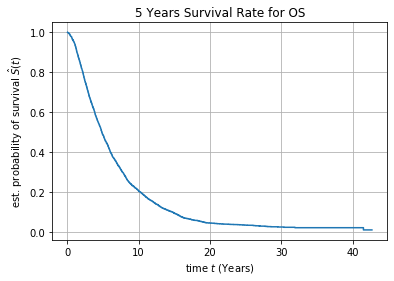

In [5]:
from sksurv.nonparametric import kaplan_meier_estimator

YEAR = 5
STYPE = "OS"
k = plotGraph(df_dict,YEAR, STYPE, 1)

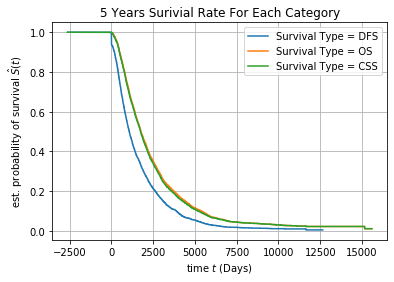

In [6]:
Years = 5

for survival in ("DFS", "OS", 'CSS'):
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        df_dict['{}_years'.format(YEAR)][survival]['status'],
        df_dict['{}_years'.format(YEAR)][survival]['{}_days'.format(survival)])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Survival Type = {}".format(survival))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (Days)")
plt.title("{} Years Surivial Rate For Each Category".format(YEAR))
plt.grid(True)
plt.legend(loc="best")

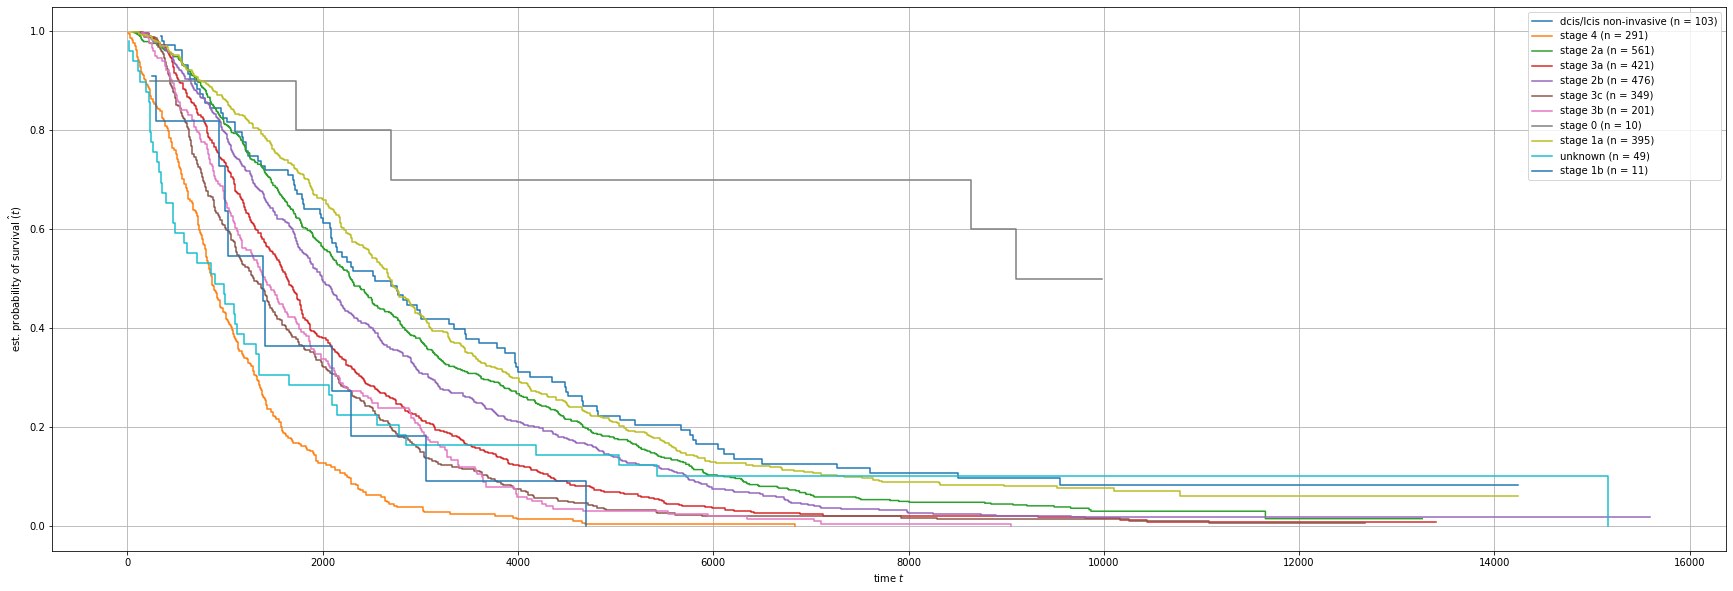

In [7]:
plt.rcParams["figure.figsize"] = (30,10)

for value in df_dict['{}_years'.format(YEAR)]['OS']["TNM_Stage"].unique():
    mask = df_dict['{}_years'.format(YEAR)]['OS']["TNM_Stage"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(df_dict['{}_years'.format(YEAR)][STYPE]['status'][mask],
                                                           df_dict['{}_years'.format(YEAR)][STYPE]['{}_days'.format(STYPE)][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label= '{} (n = {})'.format(value, mask.sum()))

plt.ylabel("est. probability of survival $\hat(t)$")
plt.xlabel("time $t$")
plt.grid(True)
plt.legend(loc="best")

### Selecting population pool

Survival times are subject to right-censoring, therefore, we need to consider an individual's status
in addition to survival time. To be fully compatible with scikit-learn, Status and Survival_in_days
need to be stored as a structured array with the first field indicating whether the actual survival time
was observed or if was censored, and the second field denoting the observerd survival time,
which corresponds to the time of death (if Status == 'dead', $\delta = 1$) or the last time that
person was contacted (if Status == 'alive', $\delta = 0$).


In [8]:
YEAR = 1
STYPE = "OS"
x_features = list(['tstage','nstage', 'Mstage', 'ER', 'PR', 'Her2', 'size_precise', 'nodespos', 'Age_@_Dx'])
y_features = list(['status','OS_days'])

X, Y = settingXY(df_dict, x_features, y_features, YEAR, STYPE)

X_train, X_test, Y_train, Y_test = train_test(X, Y)

print("X shape: {}".format(X.shape))
print("Y shape: {}".format(Y.shape))

X shape: (15118, 43)
Y shape: (15118,)


### Calculation matrix for CoxPHSurvivalAnalysis - Cox's proportional hazard's model

tol is like the p value
|1 - (new neg. log-likelihood / old neg. log-likelihood) | < tol

In [9]:
CoxEstimator, Log_Hazard_Ratio = Cox(X,Y)
Log_Hazard_Ratio.head(5)

,Log Hazarad Ratio
nstage=n1b,-5.684867
nstage=n1c,-4.269756
ER=unknown,-1.986761
ER=positive,-1.669192
ER=negative,-1.309310


In [10]:
Log_Hazard_Ratio.tail(5)

,Log Hazarad Ratio
tstage=t4c,1.173593
tstage=t4a,1.199057
tstage=t4b,1.208082
Mstage=m1,1.318424
tstage=t4,1.398815


### Measuring the Performance of Survival Models
Our test data is usually subject to censoring (only verified records are available, events happening in between is skipped), therefore metrics like root mean squared error or correlation are unsuitable. Instead, we use generalization of the area under the receiver operating characteristic (ROC) curve called Harrell's concordance index or c-index.

The interpretation is identical to the traditional area under the ROC curve metric for binary classification:

- a value of 0.5 denotes a random model,
- a value of 1.0 denotes a perfect model,
- a value of 0.0 denotes a perfectly wrong model.

In [11]:
from sksurv.metrics import concordance_index_censored

prediction = CoxEstimator.predict(X_test)
result = concordance_index_censored(Y_test["status"], Y_test["OS_days"], prediction)
result[0]

0.7964709463612667

### Feature Selection - (C index)

In [12]:
scores = fit_and_score_features(X_test.values, Y_test)
pd.Series(scores, index=X_test.columns).sort_values(ascending=False).head(10)

size_precise    0.701729
nodespos        0.668167
Age_@_Dx        0.600119
PR=negative     0.590873
ER=negative     0.581894
PR=positive     0.571607
tstage=tis      0.564391
ER=positive     0.563076
Mstage=m1       0.562137
tstage=t3       0.558399
dtype: float64

### Determine features that are useful - Cox

In [13]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.pipeline import Pipeline

# pipe = Pipeline([('encode', OneHotEncoder()),
#                  ('select', SelectKBest(fit_and_score_features, k=3)),
#                  ('model', CoxPHSurvivalAnalysis(alpha = 1e-6, tol= 1e-6))])

# from sklearn.model_selection import GridSearchCV

# param_grid = {'select__k': np.arange(1, X.shape[1] + 1)}
# gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=3, iid=True)
# gcv.fit(X, Y)

# pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

# pipe.set_params(**gcv.best_params_)
# pipe.fit(X, Y)

# encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
# pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

### RandomSurvivalForest

In [14]:
from sksurv.ensemble import RandomSurvivalForest

random_state = 20
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, Y_train)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=1000, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [15]:
rsf.score(X_test, Y_test)

0.7988279465691461

### Predicting

For prediction, a sample is dropped down each tree in the forest until it reaches a terminal node. Data in each terminal is used to non-parametrically estimate the survival and cumulative hazard function using the Kaplan-Meier and Nelson-Aalen estimator, respectively. In addition, a risk score can be computed that represents the expected number of events for one particular terminal node. The ensemble prediction is simply the average across all trees in the forest.

In [16]:
X_test_values = X_test.values
a = np.empty(X_test.shape[0], dtype=[("Age_@_Dx", float), ("nodespos", float)])
a["Age_@_Dx"] = X_test_values[:, -1]
a["nodespos"] = X_test_values[:, -2]

sort_idx = np.argsort(a, order=["nodespos", "Age_@_Dx"])

X_test_sel = pd.DataFrame(
#     X_test_values[np.concatenate((sort_idx[:3], sort_idx[-3:]))],
    X_test_values[(sort_idx[:1])],
    columns=list(X_test.columns))

In [17]:
#predict risk score
pd.Series(rsf.predict(X_test_sel))

0    55.843216
dtype: float64

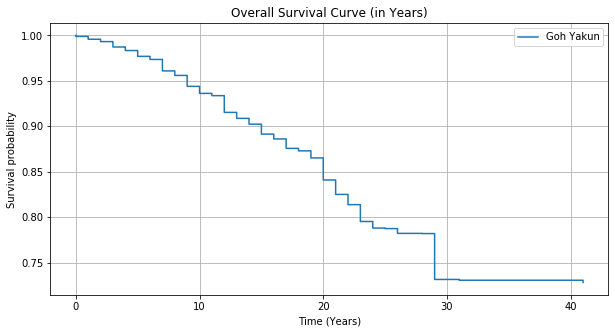

In [23]:
plt.rcParams["figure.figsize"] = (10,5)
surv = rsf.predict_survival_function(X_test_sel)

# days
# for i, s in enumerate(surv):
#     plt.step(rsf.event_times_, s, where="post", label="Goh Yakun")
# plt.ylabel("Survival probability")
# plt.xlabel("Time (Days)")
# plt.title("Overall Survival Curve (Days)")
# plt.grid(True)
# plt.legend()

# years
for i, s in enumerate(surv):
    plt.step(rsf.event_times_//365.25, s, where="post", label="Goh Yakun")
plt.ylabel("Survival probability")
plt.xlabel("Time (Years)")
plt.title("Overall Survival Curve (in Years)")
plt.grid(True)
plt.legend()

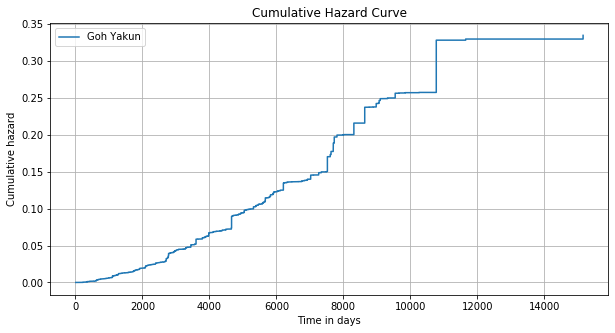

In [25]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label="Goh Yakun")
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.title("Cumulative Hazard Curve")
plt.grid(True)
plt.legend()

In [20]:
interval = list([0.5,1,2,5,10])
raw_data = {'tstage':['tis'],\
            'ER': ['positive'],\
            'PR': ['positive'],\
            'Her2': ['negative'],\
            'size_precise': [1.3],\
            'nodespos': [0],\
            'Age_@_Dx': [21],\
            'nstage': ['n0'],\
            'Mstage': ['m0']}
raw_data = pd.DataFrame.from_dict(raw_data)

z = survivalTable(rsf,raw_data,interval)
print(z.values())

dict_values([0.9982898546809512, 0.9957323164007198, 0.9931109542991217, 0.9768756998902415, 0.9360823591392873])


In [21]:
# tmp = pd.DataFrame({'x':rsf.event_times_,'y':s}, columns = ['x','y'])
# tmp.to_csv('C:\\Users\\LINGXING\\Desktop\\patient1.csv', index = False)

### Permutation-based Feature Importance

In [22]:
import eli5
from eli5.sklearn import PermutationImportance

feature_names = X.columns.tolist()
perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(X_test, Y_test)
eli5.show_weights(perm, feature_names=feature_names)

KeyboardInterrupt: 

### Testing

In [ ]:
# new_X_features = X_features.dropna(axis = 0, how ='any')  
# print("Old data frame length:", len(X_features)) 
# print("New data frame length:", len(new_X_features)) 
# print("Number of rows with at least 1 NA value: ", (len(X_features)-len(new_X_features))) 

In [ ]:
# hyperparams = {
#     'L2_reg': 10.0,
#     'batch_norm': True,
#     'dropout': 0.4,
#     'hidden_layers_sizes': [25, 25],
#     'learning_rate': 1e-05,
#     'lr_decay': 0.001,
#     'momentum': 0.9,
#     'n_in': train_data['x'].shape[1],
#     'standardize': True
# }

### Limitation: Not enough data per group

In [ ]:
# X_features = clinical[['NRIC','Gender', 'c_tstage', 'cNstage', 'cMstage', 'c_Staging', 'tstage',\
#                       'nstage', 'Mstage', 'p_Staging', 'diff', 'TNM_Stage', 'ProgStage_AJCC8',\
#                       'ER', 'PR', 'cerbB2', 'Her2', 'size_precise', 'nodespos', 'Age_@_Dx']]

# X_features['COUNTER'] =1  
# grouped_data = X_features.groupby(['TNM_Stage','ER', 'PR','Her2']).agg({'COUNTER': ['count']})
# grouped_data = grouped_data.reset_index()
# df = pd.DataFrame(data=grouped_data)

thought process
1. calculate the years of DFS, OS, CSS
2. group the data into disease features. calculate the the mean and sd
3. caculate the z score and probility area
4. split the df into x and y. X = clinical features, Y = years DFS, years CSS, years OS, z score, probility area and SD for modelling category

In [ ]:
# from scipy.stats import zscore
# ''' 
#     calculate avg death for dfs, os, css
# ''' 

# # get all the death records
# death_clinical = clinical[clinical['death_age'].notnull()] # shape: (5910, 33)

# # get avg for DFS, OS, CSS for those who has deceased
# dfs_mean = death_clinical['DFS_years'].mean(axis = 0)
# os_mean = death_clinical['OS_years'].mean(axis = 0)
# css_mean = death_clinical['CSS_years'].mean(axis = 0)

# # get sd for DFS, OS, CSS for those who has deceased
# dfs_std = death_clinical['DFS_years'].std(axis = 0,ddof=1)
# os_std = death_clinical['OS_years'].std(axis = 0,ddof=1)
# css_std = death_clinical['CSS_years'].std(axis = 0,ddof=1)

# print("dfs_mean: {}, os_mean: {}, css_mean: {}".format(dfs_mean,os_mean,css_mean))
# print("dfs_std: {}, os_std: {}, css_std: {}".format(dfs_std,os_std,css_std))

# for x in ['DFS_years', 'OS_years','CSS_years']:
#     death_clinical["{}_zscore".format(x)] = death_clinical[[x]].apply(zscore)

# death_clinical.head(10)
